### Instalando librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
import keras

from keras.models import Sequential
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
tf.__version__

'2.2.0'

### Lectura de datos csv

In [3]:
train_df=pd.read_csv('../data/mitbih_train.csv',header=None)
test_df=pd.read_csv('../data/mitbih_test.csv',header=None)

### Preprocesamiento

In [4]:
from sklearn.utils import resample

df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

### Shaping

In [5]:
target_train = train_df[187]
target_test = test_df[187]

y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

In [6]:
y_test.shape

(21892, 5)

In [7]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

print('Antes del reshaping: ', X_train.shape)

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

print('Despues del reshaping: ', X_train.shape)

Antes del reshaping:  (100000, 186)
Despues del reshaping:  (100000, 186, 1)


### Modelo

In [9]:
from keras.layers import Bidirectional, LSTM

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]))))

model.add(Dense(32))
model.add(Dense(5, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='lstm_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(X_train, y_train,epochs=100,callbacks=callbacks, batch_size=4096,validation_data=(X_test,y_test))

Epoch 1/100
25/25 [==============================] - 85s 3s/step - loss: 0.5940 - accuracy: 0.1972 - val_loss: 0.4867 - val_accuracy: 0.0735
Epoch 2/100
25/25 [==============================] - 87s 3s/step - loss: 0.5027 - accuracy: 0.2338 - val_loss: 0.5106 - val_accuracy: 0.0577
Epoch 3/100
25/25 [==============================] - 86s 3s/step - loss: 0.4961 - accuracy: 0.2246 - val_loss: 0.4991 - val_accuracy: 0.0742
Epoch 4/100
25/25 [==============================] - 86s 3s/step - loss: 0.4879 - accuracy: 0.3478 - val_loss: 0.4933 - val_accuracy: 0.0769
Epoch 5/100
25/25 [==============================] - 86s 3s/step - loss: 0.4647 - accuracy: 0.4313 - val_loss: 0.5018 - val_accuracy: 0.1105
Epoch 6/100
25/25 [==============================] - 88s 4s/step - loss: 0.4322 - accuracy: 0.4960 - val_loss: 0.4731 - val_accuracy: 0.1327
Epoch 7/100
25/25 [==============================] - 88s 4s/step - loss: 0.3926 - accuracy: 0.5420 - val_loss: 0.4581 - val_accuracy: 0.3315
Epoch 8/100
2

### Ploting results

In [10]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

Accuracy: 80.93%


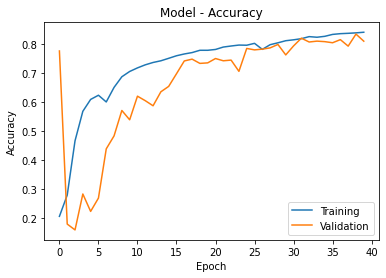

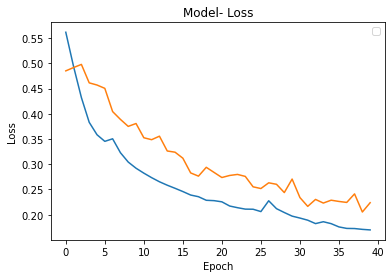

In [12]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

### Confusion matrix

Normalized confusion matrix


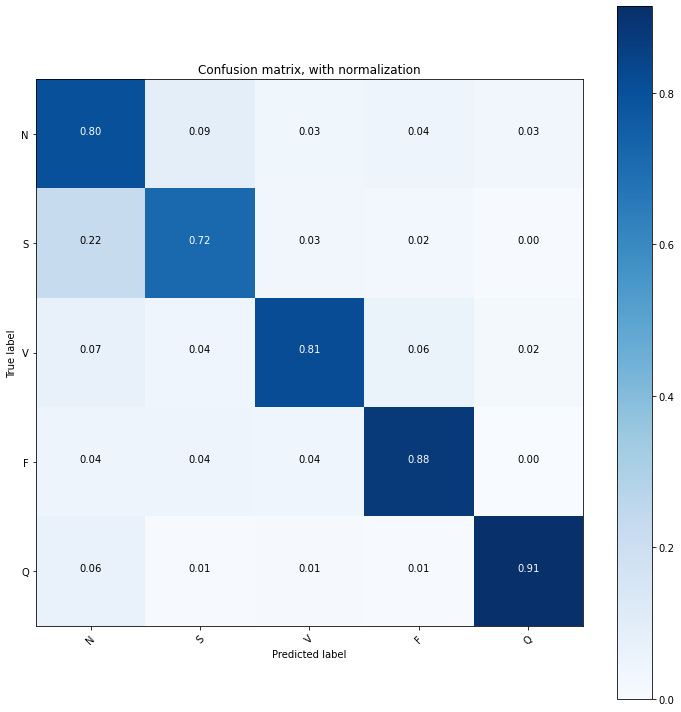

In [13]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()